In [5]:
import numpy as np
import torch
from brevitas.nn import QuantIdentity
from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy import Node
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from aeon.datasets import load_classification

# ========== Configuration ==========
N_values = [50, 100, 200,300,400,500]
bit_widths = [4, 6, 8]
threshold_scale = 0.0078125
accuracies = {}  # {N: {bit_width: acc}}

# ========== Load and Prepare Data ==========
X_train, y_train = load_classification('NonInvasiveFetalECGThorax2', split='train')
X_test, y_test = load_classification('NonInvasiveFetalECGThorax2', split='test')

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
y_test_labels = np.argmax(y_test_cat, axis=1)

X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[2])
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[2])
X_full = np.append(X_train_reshaped, X_test_reshaped, axis=0)

# ========== Helper Functions ==========

def extract_Qinput(input, num_bits=8):
    quant_identity = QuantIdentity(return_quant_tensor=True, bit_width=num_bits)
    float_input = torch.tensor(input, dtype=torch.float32)
    quant_input = quant_identity(float_input)
    out = quant_input.int().detach().numpy()
    scale = quant_input.scale.detach().numpy()
    zero_point = quant_input.zero_point.numpy()
    return out, scale, zero_point

def compute_integer_thresholds(scale):
    a, b = -1, 1
    a_scaled = np.int32(a / scale)
    b_scaled = np.int32(b / scale)
    return a_scaled, b_scaled

def piecewise_linear_hard_tanh_integer(x, a_scaled, b_scaled, bit_width):
    x = np.where(x < a_scaled, a_scaled, x)
    x = np.where(x > b_scaled, b_scaled, x)
    q_range = 2 ** bit_width
    return ((x + b_scaled) / q_range).astype(np.int32)

def make_forward_fn(N, a_scaled, b_scaled, c_scaled, d_scaled, int_Win, int_Wr, int_bias, bit_width):
    def forward(node: Node, x: np.ndarray) -> np.ndarray:
        state = node.state().astype(np.int32).reshape(1, N)
        r = state @ int_Wr.astype(np.int32)
        s = x @ int_Win.astype(np.int32).T
        s = s.reshape(1, N)
        bias_res = int_bias.reshape(1, N)
        out_r = piecewise_linear_hard_tanh_integer(s, a_scaled, b_scaled, bit_width)
        out_s = piecewise_linear_hard_tanh_integer(r, c_scaled, d_scaled, bit_width)
        return out_r + out_s + bias_res
    return forward

# ========== Main Loop ==========
for N in N_values:
    print(f"\n=== Training FP Model for N={N} ===")
    # Train floating point model
    reservoir = Reservoir(units=N, input_dim=X_train_reshaped.shape[1], sr=0.4, input_connectivity=0.8,
                          rc_connectivity=0.1, input_scaling=0.3, lr=1, seed=42)
    readout = Ridge(ridge=1e-1)
    esn_model = reservoir >> readout
    esn_model.fit(X_train_reshaped, y_train_cat)
    
    y_pred = esn_model.run(X_test_reshaped)
    y_pred_labels = np.argmax(y_pred, axis=1)
    acc_fp = np.mean(y_pred_labels == y_test_labels)
    print(f"Floating-Point Accuracy: {acc_fp*100:.2f}%")

    # Store FP accuracy
    accuracies[N] = {'FP': acc_fp}

    # Extract and quantize weights
    Win = esn_model.nodes[0].Win.todense()
    Wr = esn_model.nodes[0].W.todense()
    bias = esn_model.nodes[0].bias.todense()

    for bw in bit_widths:
        print(f"→ Quantizing at {bw} bits for N={N}")
        int_x, x_scale, _ = extract_Qinput(X_full, num_bits=bw)
        int_Win, scale_Win, _ = extract_Qinput(Win, num_bits=bw)
        int_Wr, scale_Wr, _ = extract_Qinput(Wr, num_bits=bw)
        int_bias, scale_bias, _ = extract_Qinput(bias, num_bits=bw)

        input_scale = scale_Win * x_scale
        reservoir_scale = scale_Wr * threshold_scale
        a_scaled, b_scaled = compute_integer_thresholds(input_scale)
        c_scaled, d_scaled = compute_integer_thresholds(reservoir_scale)

        forward_fn = make_forward_fn(N, a_scaled, b_scaled, c_scaled, d_scaled,
                                     int_Win, int_Wr, int_bias, bw)

        def init(node, x=None, y=None):
            node.set_input_dim(x.shape[1])
            node.set_output_dim(N)
            node.set_param("Win", int_Win)
            node.set_param("Wr", int_Wr)
            node.set_param("Bias", int_bias)

        class CustomNode(Node):
            def __init__(self):
                super().__init__(
                    forward=forward_fn,
                    initializer=init,
                    params={"Win": None, "Wr": None, "Bias": None},
                    hypers={},
                    name=f"QESN_{N}_{bw}bit"
                )

        q_node = CustomNode()
        readout_q = Ridge(ridge=1e-1)
        model_q = q_node >> readout_q

        # Train quantized model
        q_states_train = q_node.run(int_x[:len(X_train_reshaped)].astype(np.float32)) * threshold_scale
        readout_q.fit(q_states_train.astype(np.float64), y_train_cat)

        q_states_test = q_node.run(int_x[len(X_train_reshaped):].astype(np.float32)) * threshold_scale
        y_pred_q = readout_q.run(q_states_test.astype(np.float32))
        y_pred_q_labels = np.argmax(y_pred_q, axis=1)

        acc_q = np.mean(y_pred_q_labels == y_test_labels)
        print(f"Quantized INT{bw} Accuracy: {acc_q*100:.2f}%")
        accuracies[N][f'INT{bw}'] = acc_q

# ========== Summary ==========
print("\n=== Accuracy Summary ===")
header = f"{'N':>5} | {'FP':>6} | " + " | ".join([f'INT{bw:>2}' for bw in bit_widths])
print(header)
print('-' * len(header))
for N in N_values:
    line = f"{N:>5} | {accuracies[N]['FP']*100:6.2f} "
    for bw in bit_widths:
        acc = accuracies[N].get(f'INT{bw}', 0)
        line += f"| {acc*100:6.2f} "
    print(line)



=== Training FP Model for N=50 ===


Running Model-48: 1800it [00:00, 15159.07it/s]?, ?it/s]
Running Model-48: 100%|██████████| 1/1 [00:00<00:00,  8.27it/s]

Fitting node Ridge-48...



Running Model-48: 1965it [00:00, 16003.17it/s]         


Floating-Point Accuracy: 62.29%
→ Quantizing at 4 bits for N=50


Running Ridge-49: 100%|██████████| 1965/1965 [00:00<00:00, 135386.81it/s]


Quantized INT4 Accuracy: 47.94%
→ Quantizing at 6 bits for N=50


Running Ridge-50: 100%|██████████| 1965/1965 [00:00<00:00, 135591.72it/s]


Quantized INT6 Accuracy: 56.18%
→ Quantizing at 8 bits for N=50


Running Ridge-51: 100%|██████████| 1965/1965 [00:00<00:00, 48056.91it/s]


Quantized INT8 Accuracy: 64.07%

=== Training FP Model for N=100 ===


Running Model-52: 1800it [00:00, 9954.31it/s]<?, ?it/s]
Running Model-52: 100%|██████████| 1/1 [00:00<00:00,  5.41it/s]


Fitting node Ridge-52...


Running Model-52: 1965it [00:00, 13383.19it/s]         


Floating-Point Accuracy: 70.33%
→ Quantizing at 4 bits for N=100


Running Ridge-53: 100%|██████████| 1965/1965 [00:00<00:00, 127978.38it/s]


Quantized INT4 Accuracy: 49.36%
→ Quantizing at 6 bits for N=100


Running Ridge-54: 100%|██████████| 1965/1965 [00:00<00:00, 74844.55it/s]


Quantized INT6 Accuracy: 59.03%
→ Quantizing at 8 bits for N=100


Running Ridge-55: 100%|██████████| 1965/1965 [00:00<00:00, 40652.30it/s]


Quantized INT8 Accuracy: 63.92%

=== Training FP Model for N=200 ===


Running Model-56: 1800it [00:00, 8841.51it/s]<?, ?it/s]
Running Model-56: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


Fitting node Ridge-56...


Running Model-56: 1965it [00:00, 9554.48it/s]          


Floating-Point Accuracy: 84.58%
→ Quantizing at 4 bits for N=200


Running Ridge-57: 100%|██████████| 1965/1965 [00:00<00:00, 55109.24it/s]


Quantized INT4 Accuracy: 71.20%
→ Quantizing at 6 bits for N=200


Running Ridge-58: 100%|██████████| 1965/1965 [00:00<00:00, 70411.50it/s]


Quantized INT6 Accuracy: 78.52%
→ Quantizing at 8 bits for N=200


Running Ridge-59: 100%|██████████| 1965/1965 [00:00<00:00, 72921.51it/s]


Quantized INT8 Accuracy: 82.09%

=== Training FP Model for N=300 ===


Running Model-60: 1800it [00:00, 7163.97it/s]<?, ?it/s]
Running Model-60: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Fitting node Ridge-60...


Running Model-60: 1965it [00:00, 5142.52it/s]          


Floating-Point Accuracy: 87.53%
→ Quantizing at 4 bits for N=300


Running Ridge-61: 100%|██████████| 1965/1965 [00:00<00:00, 38038.00it/s]


Quantized INT4 Accuracy: 72.52%
→ Quantizing at 6 bits for N=300


Running Ridge-62: 100%|██████████| 1965/1965 [00:00<00:00, 44445.32it/s]


Quantized INT6 Accuracy: 82.09%
→ Quantizing at 8 bits for N=300


Running Ridge-63: 100%|██████████| 1965/1965 [00:00<00:00, 70809.56it/s]


Quantized INT8 Accuracy: 85.75%

=== Training FP Model for N=400 ===


Running Model-64: 1800it [00:00, 6085.22it/s]<?, ?it/s]
Running Model-64: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


Fitting node Ridge-64...


Running Model-64: 1965it [00:00, 4375.87it/s]          


Floating-Point Accuracy: 88.30%
→ Quantizing at 4 bits for N=400


Running Ridge-65: 100%|██████████| 1965/1965 [00:00<00:00, 67433.09it/s]


Quantized INT4 Accuracy: 75.78%
→ Quantizing at 6 bits for N=400


Running Ridge-66: 100%|██████████| 1965/1965 [00:00<00:00, 63293.35it/s]


Quantized INT6 Accuracy: 83.97%
→ Quantizing at 8 bits for N=400


Running Ridge-67: 100%|██████████| 1965/1965 [00:00<00:00, 63330.32it/s]


Quantized INT8 Accuracy: 86.77%

=== Training FP Model for N=500 ===


Running Model-68: 1800it [00:00, 5252.51it/s]<?, ?it/s]
Running Model-68: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


Fitting node Ridge-68...


Running Model-68: 1965it [00:00, 5555.75it/s]          


Floating-Point Accuracy: 88.65%
→ Quantizing at 4 bits for N=500


Running Ridge-69: 100%|██████████| 1965/1965 [00:00<00:00, 29228.03it/s]


Quantized INT4 Accuracy: 76.79%
→ Quantizing at 6 bits for N=500


Running Ridge-70: 100%|██████████| 1965/1965 [00:00<00:00, 65861.75it/s]


Quantized INT6 Accuracy: 84.63%
→ Quantizing at 8 bits for N=500


Running Ridge-71: 100%|██████████| 1965/1965 [00:00<00:00, 61142.36it/s]

Quantized INT8 Accuracy: 87.84%

=== Accuracy Summary ===
    N |     FP | INT 4 | INT 6 | INT 8
--------------------------------------
   50 |  62.29 |  47.94 |  56.18 |  64.07 
  100 |  70.33 |  49.36 |  59.03 |  63.92 
  200 |  84.58 |  71.20 |  78.52 |  82.09 
  300 |  87.53 |  72.52 |  82.09 |  85.75 
  400 |  88.30 |  75.78 |  83.97 |  86.77 
  500 |  88.65 |  76.79 |  84.63 |  87.84 


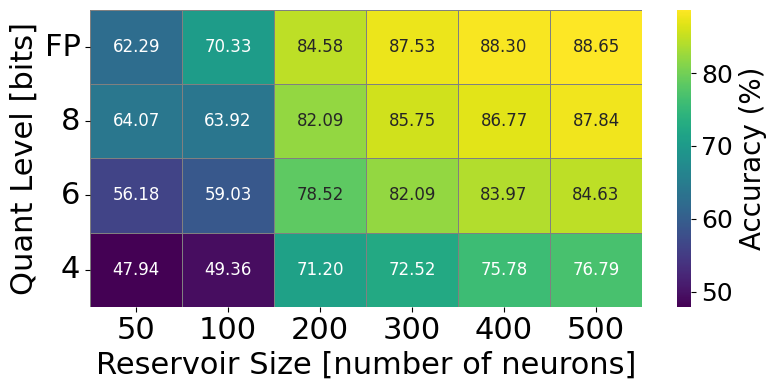

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define reversed order of quantization levels (FP on top)
quant_levels = ['FP'] + [f'INT{bw}' for bw in reversed(bit_widths)]

# Build the DataFrame: rows=Quantization Levels, columns=Reservoir Sizes
heatmap_data = {N: [accuracies[N].get(level, 0) * 100 for level in quant_levels] for N in N_values}
df = pd.DataFrame(heatmap_data, index=quant_levels)

# Ensure proper column order
df = df[[50, 100, 200, 300, 400, 500]]

# Prepare labels without "INT"
y_labels = ['FP'] + [str(bw) for bw in reversed(bit_widths)]

# Plot the heatmap
plt.figure(figsize=(8, 4))
ax = sns.heatmap(df, annot=True, fmt=".2f", cmap="viridis",
                 cbar_kws={'label': 'Accuracy (%)'},
                 annot_kws={"size": 12}, linewidths=0.5, linecolor='gray')

# Set axis labels and ticks
plt.xlabel('Reservoir Size [number of neurons]', fontsize=22)
plt.ylabel('Quant Level [bits]', fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(ticks=[i + 0.5 for i in range(len(y_labels))], labels=y_labels, fontsize=22, rotation=0)

# Set colorbar label font size
colorbar = ax.collections[0].colorbar
colorbar.ax.tick_params(labelsize=18)
colorbar.set_label('Accuracy (%)', fontsize=20)

plt.tight_layout()
plt.savefig("classification_ECG.pdf", bbox_inches='tight')
plt.show()


In [2]:
# -*- coding: utf-8 -*-
# Full script: FP + Quantized ESN on NonInvasiveFetalECGThorax2
# Logs Accuracy, F1-score, and Recall for each N and bit-width.

import numpy as np
import torch
from brevitas.nn import QuantIdentity
from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy import Node
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, recall_score
from aeon.datasets import load_classification

# ========== Configuration ==========
N_values = [50, 100, 200, 300, 400, 500]
bit_widths = [4, 6, 8]
threshold_scale = 0.0078125
accuracies = {}  # {N: { 'FP': acc, 'FP_f1': f1, 'FP_recall': rec, 'INT4': acc, 'INT4_f1': f1, 'INT4_recall': rec, ... }}

# ========== Load and Prepare Data ==========
X_train, y_train = load_classification('NonInvasiveFetalECGThorax2', split='train')
X_test, y_test = load_classification('NonInvasiveFetalECGThorax2', split='test')

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
y_test_labels = np.argmax(y_test_cat, axis=1)

# flatten time dimension: (n_samples, n_channels, n_time) -> (n_samples, n_time)
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[2])
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[2])
X_full = np.append(X_train_reshaped, X_test_reshaped, axis=0)

# ========== Helper Functions ==========

def extract_Qinput(input, num_bits=8):
    quant_identity = QuantIdentity(return_quant_tensor=True, bit_width=num_bits)
    float_input = torch.tensor(input, dtype=torch.float32)
    quant_input = quant_identity(float_input)
    out = quant_input.int().detach().numpy()
    scale = quant_input.scale.detach().numpy()
    zero_point = quant_input.zero_point.numpy()
    return out, scale, zero_point

def compute_integer_thresholds(scale):
    a, b = -1, 1
    a_scaled = np.int32(a / scale)
    b_scaled = np.int32(b / scale)
    return a_scaled, b_scaled

def piecewise_linear_hard_tanh_integer(x, a_scaled, b_scaled, bit_width):
    x = np.where(x < a_scaled, a_scaled, x)
    x = np.where(x > b_scaled, b_scaled, x)
    q_range = 2 ** bit_width
    return ((x + b_scaled) / q_range).astype(np.int32)

def make_forward_fn(N, a_scaled, b_scaled, c_scaled, d_scaled, int_Win, int_Wr, int_bias, bit_width):
    def forward(node: Node, x: np.ndarray) -> np.ndarray:
        state = node.state().astype(np.int32).reshape(1, N)
        r = state @ int_Wr.astype(np.int32)
        s = x @ int_Win.astype(np.int32).T
        s = s.reshape(1, N)
        bias_res = int_bias.reshape(1, N)
        out_r = piecewise_linear_hard_tanh_integer(s, a_scaled, b_scaled, bit_width)
        out_s = piecewise_linear_hard_tanh_integer(r, c_scaled, d_scaled, bit_width)
        return out_r + out_s + bias_res
    return forward

# ========== Main Loop ==========
for N in N_values:
    print(f"\n=== Training FP Model for N={N} ===")

    # Train floating point model
    reservoir = Reservoir(
        units=N,
        input_dim=X_train_reshaped.shape[1],
        sr=0.4,
        input_connectivity=0.8,
        rc_connectivity=0.1,
        input_scaling=0.3,
        lr=1,
        seed=42
    )
    readout = Ridge(ridge=1e-1)
    esn_model = reservoir >> readout
    esn_model.fit(X_train_reshaped, y_train_cat)

    # FP predictions and metrics
    y_pred = esn_model.run(X_test_reshaped)
    y_pred_labels = np.argmax(y_pred, axis=1)

    acc_fp = np.mean(y_pred_labels == y_test_labels)
    f1_fp = f1_score(y_test_labels, y_pred_labels, average="weighted")
    recall_fp = recall_score(y_test_labels, y_pred_labels, average="weighted")

    print(f"Floating-Point Accuracy: {acc_fp*100:.2f}% | F1 (w): {f1_fp*100:.2f}% | Recall (w): {recall_fp*100:.2f}%")

    # Store FP metrics
    accuracies[N] = {
        'FP': acc_fp,
        'FP_f1': f1_fp,
        'FP_recall': recall_fp
    }

    # Extract and quantize weights from the trained reservoir
    Win = esn_model.nodes[0].Win.todense()
    Wr = esn_model.nodes[0].W.todense()
    bias = esn_model.nodes[0].bias.todense()

    for bw in bit_widths:
        print(f"→ Quantizing at {bw} bits for N={N}")

        # Quantize inputs/weights
        int_x, x_scale, _ = extract_Qinput(X_full, num_bits=bw)
        int_Win, scale_Win, _ = extract_Qinput(Win, num_bits=bw)
        int_Wr, scale_Wr, _ = extract_Qinput(Wr, num_bits=bw)
        int_bias, scale_bias, _ = extract_Qinput(bias, num_bits=bw)

        input_scale = scale_Win * x_scale
        reservoir_scale = scale_Wr * threshold_scale
        a_scaled, b_scaled = compute_integer_thresholds(input_scale)
        c_scaled, d_scaled = compute_integer_thresholds(reservoir_scale)

        forward_fn = make_forward_fn(
            N, a_scaled, b_scaled, c_scaled, d_scaled,
            int_Win, int_Wr, int_bias, bw
        )

        def init(node, x=None, y=None):
            node.set_input_dim(x.shape[1])
            node.set_output_dim(N)
            node.set_param("Win", int_Win)
            node.set_param("Wr", int_Wr)
            node.set_param("Bias", int_bias)

        class CustomNode(Node):
            def __init__(self):
                super().__init__(
                    forward=forward_fn,
                    initializer=init,
                    params={"Win": None, "Wr": None, "Bias": None},
                    hypers={},
                    name=f"QESN_{N}_{bw}bit"
                )

        q_node = CustomNode()
        readout_q = Ridge(ridge=1e-1)
        model_q = q_node >> readout_q

        # Train quantized readout (using scaled integer states)
        q_states_train = q_node.run(int_x[:len(X_train_reshaped)].astype(np.float32)) * threshold_scale
        readout_q.fit(q_states_train.astype(np.float64), y_train_cat)

        # Evaluate quantized model
        q_states_test = q_node.run(int_x[len(X_train_reshaped):].astype(np.float32)) * threshold_scale
        y_pred_q = readout_q.run(q_states_test.astype(np.float32))
        y_pred_q_labels = np.argmax(y_pred_q, axis=1)

        acc_q = np.mean(y_pred_q_labels == y_test_labels)
        f1_q = f1_score(y_test_labels, y_pred_q_labels, average="weighted")
        recall_q = recall_score(y_test_labels, y_pred_q_labels, average="weighted")

        print(f"Quantized INT{bw} → Acc: {acc_q*100:.2f}% | F1 (w): {f1_q*100:.2f}% | Recall (w): {recall_q*100:.2f}%")

        accuracies[N][f'INT{bw}'] = acc_q
        accuracies[N][f'INT{bw}_f1'] = f1_q
        accuracies[N][f'INT{bw}_recall'] = recall_q

# ========== Summary ==========
print("\n=== Accuracy / F1 / Recall Summary (weighted) ===")
header = f"{'N':>5} | {'FP Acc':>7} | {'FP F1':>7} | {'FP Rec':>7}"
for bw in bit_widths:
    header += f" | INT{bw} Acc | INT{bw} F1 | INT{bw} Rec"
print(header)
print('-' * len(header))

for N in N_values:
    line = f"{N:>5} | {accuracies[N]['FP']*100:7.2f} | {accuracies[N]['FP_f1']*100:7.2f} | {accuracies[N]['FP_recall']*100:7.2f}"
    for bw in bit_widths:
        line += f" | {accuracies[N][f'INT{bw}']*100:7.2f} | {accuracies[N][f'INT{bw}_f1']*100:7.2f} | {accuracies[N][f'INT{bw}_recall']*100:7.2f}"
    print(line)


2025-08-25 21:06:12.852142: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-25 21:06:12.859773: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756148772.868447 1030874 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756148772.870938 1030874 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756148772.877786 1030874 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 


=== Training FP Model for N=50 ===


Running Model-0: 1800it [00:00, 15337.66it/s]?, ?it/s]
Running Model-0: 100%|██████████| 1/1 [00:00<00:00,  8.34it/s]

Fitting node Ridge-0...



Running Model-0: 1965it [00:00, 15556.45it/s]         
/home/atousa/.local/lib/python3.10/site-packages/torch/_tensor.py:1644: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at /pytorch/c10/core/TensorImpl.h:1935.)
  return super().rename(names)


Floating-Point Accuracy: 62.29% | F1 (w): 59.20% | Recall (w): 62.29%
→ Quantizing at 4 bits for N=50


Running Ridge-1: 100%|██████████| 1965/1965 [00:00<00:00, 45236.69it/s]


Quantized INT4 → Acc: 47.94% | F1 (w): 43.69% | Recall (w): 47.94%
→ Quantizing at 6 bits for N=50


Running Ridge-2: 100%|██████████| 1965/1965 [00:00<00:00, 44098.60it/s]


Quantized INT6 → Acc: 56.18% | F1 (w): 52.36% | Recall (w): 56.18%
→ Quantizing at 8 bits for N=50


Running Ridge-3: 100%|██████████| 1965/1965 [00:00<00:00, 44982.63it/s]


Quantized INT8 → Acc: 64.07% | F1 (w): 60.54% | Recall (w): 64.07%

=== Training FP Model for N=100 ===


Running Model-4: 1800it [00:00, 11286.98it/s]?, ?it/s]
Running Model-4: 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]


Fitting node Ridge-4...


Running Model-4: 1965it [00:00, 13195.93it/s]         


Floating-Point Accuracy: 70.33% | F1 (w): 68.06% | Recall (w): 70.33%
→ Quantizing at 4 bits for N=100


Running Ridge-5: 100%|██████████| 1965/1965 [00:00<00:00, 76184.65it/s]


Quantized INT4 → Acc: 49.36% | F1 (w): 45.67% | Recall (w): 49.36%
→ Quantizing at 6 bits for N=100


Running Ridge-6: 100%|██████████| 1965/1965 [00:00<00:00, 79650.23it/s]


Quantized INT6 → Acc: 59.03% | F1 (w): 55.50% | Recall (w): 59.03%
→ Quantizing at 8 bits for N=100


Running Ridge-7: 100%|██████████| 1965/1965 [00:00<00:00, 44424.72it/s]


Quantized INT8 → Acc: 63.92% | F1 (w): 60.91% | Recall (w): 63.92%

=== Training FP Model for N=200 ===


Running Model-8: 1800it [00:00, 8846.03it/s]<?, ?it/s]
Running Model-8: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


Fitting node Ridge-8...


Running Model-8: 1965it [00:00, 9534.42it/s]          


Floating-Point Accuracy: 84.58% | F1 (w): 84.01% | Recall (w): 84.58%
→ Quantizing at 4 bits for N=200


Running Ridge-9: 100%|██████████| 1965/1965 [00:00<00:00, 54481.92it/s]


Quantized INT4 → Acc: 71.20% | F1 (w): 69.57% | Recall (w): 71.20%
→ Quantizing at 6 bits for N=200


Running Ridge-10: 100%|██████████| 1965/1965 [00:00<00:00, 43295.90it/s]


Quantized INT6 → Acc: 78.52% | F1 (w): 77.50% | Recall (w): 78.52%
→ Quantizing at 8 bits for N=200


Running Ridge-11: 100%|██████████| 1965/1965 [00:00<00:00, 75330.25it/s]


Quantized INT8 → Acc: 82.09% | F1 (w): 81.48% | Recall (w): 82.09%

=== Training FP Model for N=300 ===


Running Model-12: 1800it [00:00, 7159.52it/s]<?, ?it/s]
Running Model-12: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Fitting node Ridge-12...


Running Model-12: 1965it [00:00, 6839.76it/s]          


Floating-Point Accuracy: 87.53% | F1 (w): 87.19% | Recall (w): 87.53%
→ Quantizing at 4 bits for N=300


Running Ridge-13: 100%|██████████| 1965/1965 [00:00<00:00, 32164.28it/s]


Quantized INT4 → Acc: 72.52% | F1 (w): 70.84% | Recall (w): 72.52%
→ Quantizing at 6 bits for N=300


Running Ridge-14: 100%|██████████| 1965/1965 [00:00<00:00, 70227.31it/s]


Quantized INT6 → Acc: 82.09% | F1 (w): 81.53% | Recall (w): 82.09%
→ Quantizing at 8 bits for N=300


Running Ridge-15: 100%|██████████| 1965/1965 [00:00<00:00, 43633.07it/s]


Quantized INT8 → Acc: 85.75% | F1 (w): 85.45% | Recall (w): 85.75%

=== Training FP Model for N=400 ===


Running Model-16: 1800it [00:00, 6031.62it/s]<?, ?it/s]
Running Model-16: 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


Fitting node Ridge-16...


Running Model-16: 1965it [00:00, 6253.98it/s]          


Floating-Point Accuracy: 88.30% | F1 (w): 88.07% | Recall (w): 88.30%
→ Quantizing at 4 bits for N=400


Running Ridge-17: 100%|██████████| 1965/1965 [00:00<00:00, 67593.47it/s]


Quantized INT4 → Acc: 75.78% | F1 (w): 74.80% | Recall (w): 75.78%
→ Quantizing at 6 bits for N=400


Running Ridge-18: 100%|██████████| 1965/1965 [00:00<00:00, 60612.22it/s]


Quantized INT6 → Acc: 83.97% | F1 (w): 83.64% | Recall (w): 83.97%
→ Quantizing at 8 bits for N=400


Running Ridge-19: 100%|██████████| 1965/1965 [00:00<00:00, 46286.43it/s]


Quantized INT8 → Acc: 86.77% | F1 (w): 86.48% | Recall (w): 86.77%

=== Training FP Model for N=500 ===


Running Model-20: 1800it [00:00, 4848.41it/s]<?, ?it/s]
Running Model-20: 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


Fitting node Ridge-20...


Running Model-20: 1965it [00:00, 4734.99it/s]          


Floating-Point Accuracy: 88.65% | F1 (w): 88.51% | Recall (w): 88.65%
→ Quantizing at 4 bits for N=500


Running Ridge-21: 100%|██████████| 1965/1965 [00:00<00:00, 58062.98it/s]


Quantized INT4 → Acc: 76.79% | F1 (w): 75.85% | Recall (w): 76.79%
→ Quantizing at 6 bits for N=500


Running Ridge-22: 100%|██████████| 1965/1965 [00:00<00:00, 32274.36it/s]


Quantized INT6 → Acc: 84.63% | F1 (w): 84.15% | Recall (w): 84.63%
→ Quantizing at 8 bits for N=500


Running Ridge-23: 100%|██████████| 1965/1965 [00:00<00:00, 49548.85it/s]

Quantized INT8 → Acc: 87.84% | F1 (w): 87.58% | Recall (w): 87.84%

=== Accuracy / F1 / Recall Summary (weighted) ===
    N |  FP Acc |   FP F1 |  FP Rec | INT4 Acc | INT4 F1 | INT4 Rec | INT6 Acc | INT6 F1 | INT6 Rec | INT8 Acc | INT8 F1 | INT8 Rec
-----------------------------------------------------------------------------------------------------------------------------------
   50 |   62.29 |   59.20 |   62.29 |   47.94 |   43.69 |   47.94 |   56.18 |   52.36 |   56.18 |   64.07 |   60.54 |   64.07
  100 |   70.33 |   68.06 |   70.33 |   49.36 |   45.67 |   49.36 |   59.03 |   55.50 |   59.03 |   63.92 |   60.91 |   63.92
  200 |   84.58 |   84.01 |   84.58 |   71.20 |   69.57 |   71.20 |   78.52 |   77.50 |   78.52 |   82.09 |   81.48 |   82.09
  300 |   87.53 |   87.19 |   87.53 |   72.52 |   70.84 |   72.52 |   82.09 |   81.53 |   82.09 |   85.75 |   85.45 |   85.75
  400 |   88.30 |   88.07 |   88.30 |   75.78 |   74.80 |   75.78 |   83.97 |   83.64 |   83.97 |   86.77 |   86.4